# Part 1

In [1]:
import numpy as np
import pandas as pd
from fastai.imports import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error as mae

In [2]:
def get_sample(df,n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [3]:
def numericalize(df, col, name, max_n_cat):
    if not  pd.api.types.is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1

In [4]:
def fix_missing(df, col, name, na_dict):
    if  pd.api.types.is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

In [5]:
def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not pd.api.types.is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

# Part 2

In [7]:
TRAIN_FILE='/home/thiago.martinelli/code/main/data/pubg/train_V2.csv'
TEST_FILE='/home/thiago.martinelli/code/main/data/pubg/test_V2.csv'

In [8]:
df_raw = pd.read_csv(TRAIN_FILE, engine='python')

In [9]:
df_raw.shape

(4446966, 29)

In [10]:
train_cats(df_raw)

In [11]:
df_raw.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

In [12]:
display_all(df_raw.head().T)

,0,1,2,3,4
Id,7f96b2f878858a,eef90569b9d03c,1eaf90ac73de72,4616d365dd2853,315c96c26c9aac
groupId,4d4b580de459be,684d5656442f9e,6a4a42c3245a74,a930a9c79cd721,de04010b3458dd
matchId,a10357fd1a4a91,aeb375fc57110c,110163d8bb94ae,f1f1f4ef412d7e,6dc8ff871e21e6
assists,0,0,1,0,0
boosts,0,0,0,0,0
damageDealt,0,91.47,68,32.9,100
DBNOs,0,0,0,0,0
headshotKills,0,0,0,0,0
heals,0,0,0,0,0
killPlace,60,57,47,75,45


In [13]:
df_tr, y_tr, nas_tr = proc_df(df_raw, 'winPlacePerc', subset = 60000)

/home/thiago.martinelli/venvs/p36/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


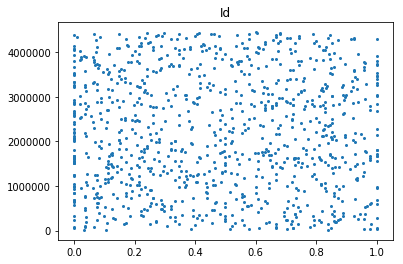

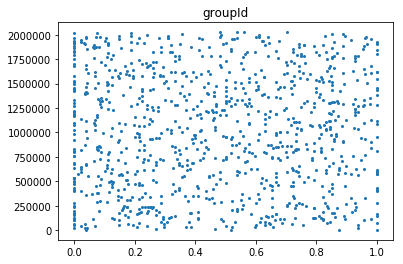

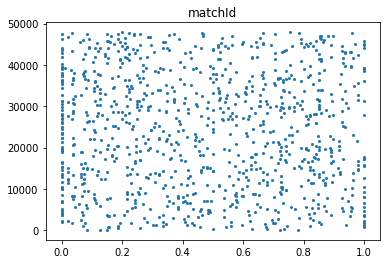

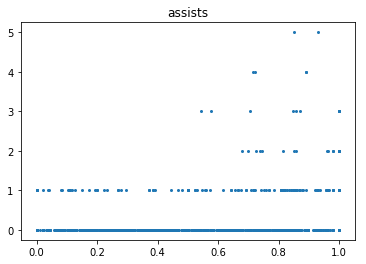

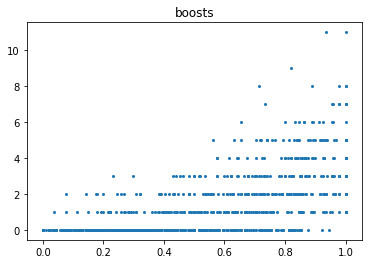

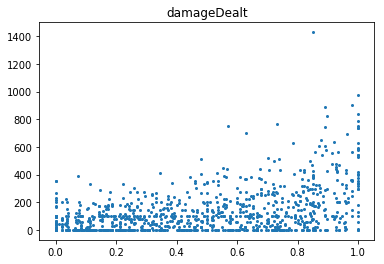

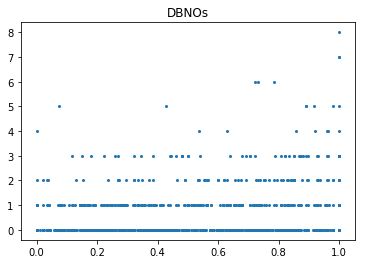

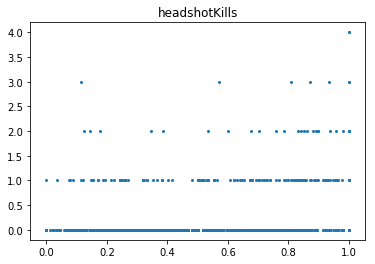

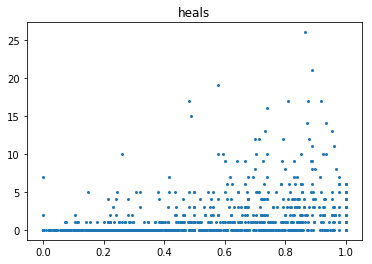

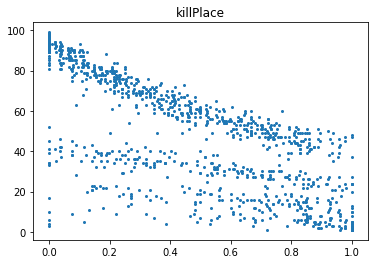

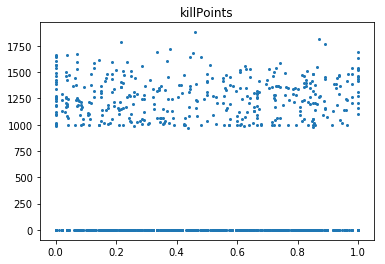

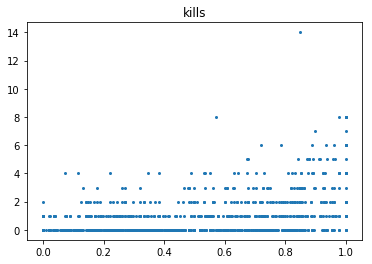

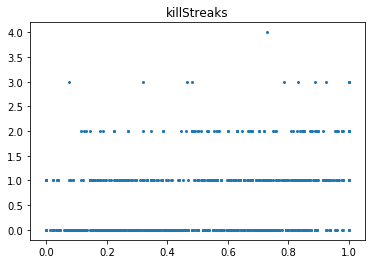

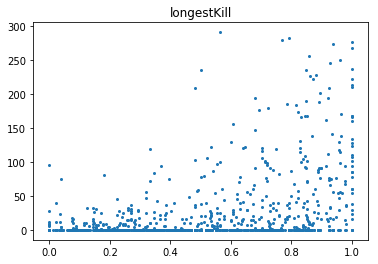

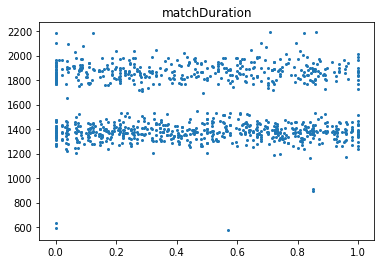

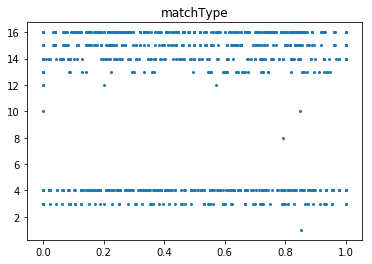

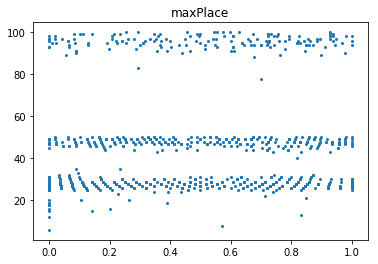

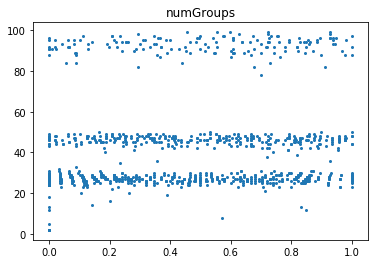

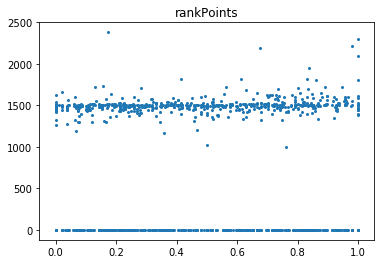

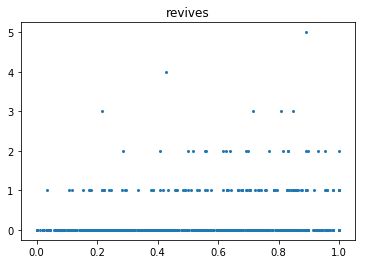

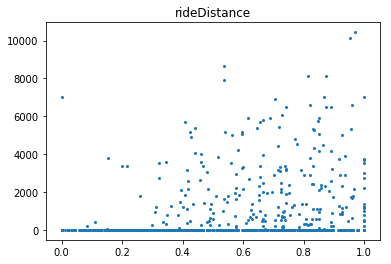

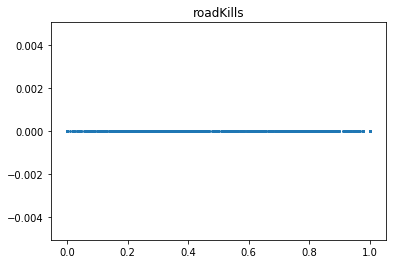

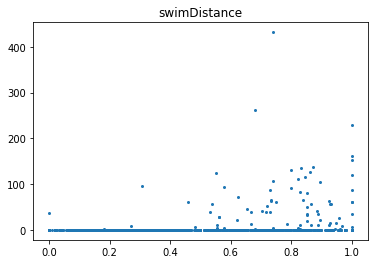

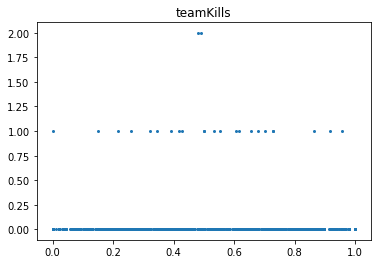

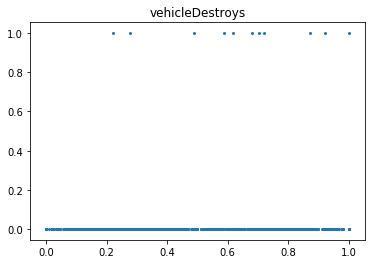

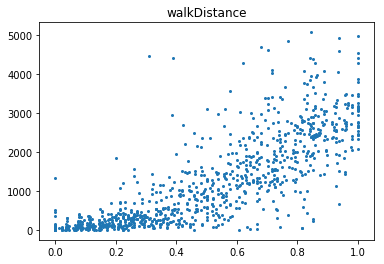

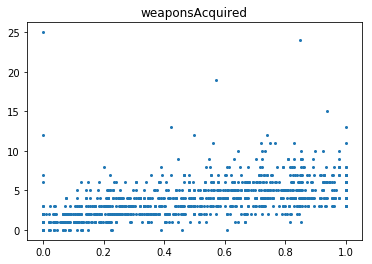

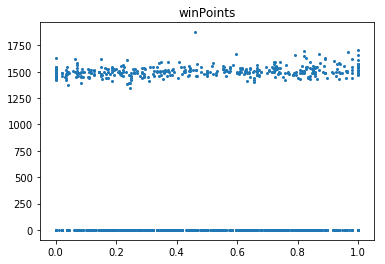

In [14]:
for i in df_tr.columns:
    f, ax = plt.subplots()
    plt.scatter(y_tr[:1000], df_tr[:1000][i], s=4)
    plt.title(i)

In [41]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

In [42]:
n_valid = 10000  # same as Kaggle's test set size
n_tr = len(df_tr)-n_valid
#raw_train, raw_valid = split_vals(df_raw, n_tr)
X_train, X_valid = split_vals(df_tr, n_tr)
y_train, y_valid = split_vals(y_tr, n_tr)
X_train.shape, y_train.shape, X_valid.shape

((50000, 28), (50000,), (10000, 28))

In [43]:
def imae(x,y): return (abs(x-y)).mean()

In [44]:
def print_score(m):
    maer = [imae(m.predict(X_train), y_train), imae(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): maer.append(m.oob_score_)
    print(maer)

In [ ]:
for n, df in df_raw.groupby('matchId'):
    print(df.shape)

In [46]:
m = RandomForestRegressor(n_jobs=-1, n_estimators = 10 )
df_raw.groupby('matchId')
m.fit(X_train, y_train)
print_score(m)

[0.02727451086823732, 0.06809807687978818, 0.9816801343571063, 0.9012117490345408]


In [ ]:
df_test = pd.read_csv(TEST_FILE)
df_ts, _, _ = proc_df(df_test)
predictions = m.predict(df_ts)
dsub = pd.DataFrame()
dsub['Id'] = df_test['Id']
dsub['winPlacePerc'] = predictions

In [ ]:
dsub.to_csv('sample_submission3.csv', index=False)